In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **PART A**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os

In [ ]:
df = np.load('/content/drive/MyDrive/cv_2/images.npy',allow_pickle = True)
df.shape

(409, 2)

shape of the data is 409,2.

In [ ]:
x = df[:,0]
y = df[:,1]
print(x.shape, y.shape)

(409,) (409,)


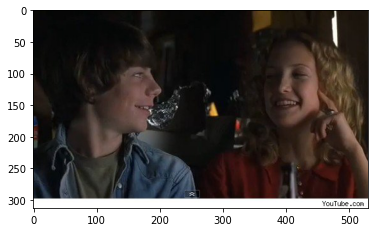

In [ ]:
import matplotlib.pyplot  as plt

plt.imshow(x[200])

(493, 656, 3)


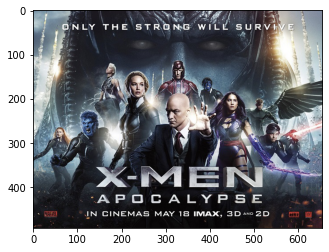

In [ ]:
plt.imshow(x[408])
print(x[408].shape)

(720, 1280, 3)


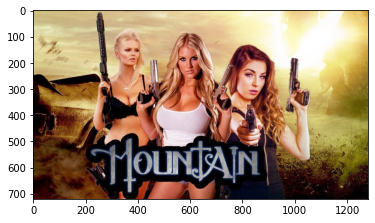

In [ ]:
plt.imshow(x[100])
print(x[100].shape)

In [ ]:
#unify all the images
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(df.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(df.shape[0]):
  img = df[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in df[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [ ]:
#train test slipt
X_train = X[:400]
X_test = X[400:]
Y_train = masks[:400] 
Y_test = masks[400:]

In [ ]:
X_train[40].shape

(224, 224, 3)

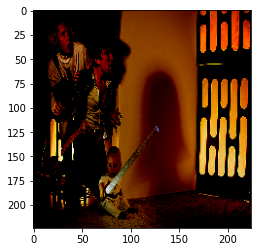

In [ ]:
plt.imshow(X_train[101])

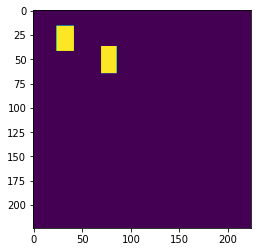

In [ ]:
plt.imshow(Y_train[101])

In [ ]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [ ]:
#building model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model


In [ ]:
model = model()
model.summary()

2019640/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [ ]:
#designing dice coeff and loss

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(X_train)//BATCH
test_steps = len(X_test)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_test) % BATCH != 0:
    test_steps += 1

model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.6683 - dice_coef: 0.3317 - recall: 0.6921 - precision: 0.3425

50/50 [==============================] - 25s 80ms/step - loss: 0.6683 - dice_coef: 0.3317 - recall: 0.6921 - precision: 0.3425 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.5558 - dice_coef: 0.4442 - recall: 0.8675 - precision: 0.4551

50/50 [==============================] - 4s 80ms/step - loss: 0.5558 - dice_coef: 0.4442 - recall: 0.8675 - precision: 0.4551 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.5182 - dice_coef: 0.4818 - recall: 0.8860 - precision: 0.5005

50/50 [==============================] - 4s 80ms/step - loss: 0.5182 - dice_coef: 0.4818 - recall: 0.8860 - precision: 0.5005 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.4959 - dice_coef: 0.5041 - recall: 0.8801 - precision: 0.5335

50/50 [==============================] - 4s 80ms/step - loss: 0.4959 - dice_coef: 0.5041 - recall: 0.8801 - precision: 0.5335 - lr: 1.0000e-04
Epoch 5/30
50/50 [==============================] - ETA: 0s - loss: 0.4683 - dice_coef: 0.5317 - recall: 0.8871 - precision: 0.5682

50/50 [==============================] - 4s 81ms/step - loss: 0.4683 - dice_coef: 0.5317 - recall: 0.8871 - precision: 0.5682 - lr: 1.0000e-04
Epoch 6/30
50/50 [==============================] - ETA: 0s - loss: 0.4587 - dice_coef: 0.5413 - recall: 0.8801 - precision: 0.5868

50/50 [==============================] - 4s 81ms/step - loss: 0.4587 - dice_coef: 0.5413 - recall: 0.8801 - precision: 0.5868 - lr: 1.0000e-04
Epoch 7/30
50/50 [==============================] - ETA: 0s - loss: 0.4414 - dice_coef: 0.5586 - recall: 0.8852 - precision: 0.6098

50/50 [==============================] - 4s 81ms/step - loss: 0.4414 - dice_coef: 0.5586 - recall: 0.8852 - precision: 0.6098 - lr: 1.0000e-04
Epoch 8/30
50/50 [==============================] - ETA: 0s - loss: 0.4306 - dice_coef: 0.5694 - recall: 0.8818 - precision: 0.6226

50/50 [==============================] - 4s 81ms/step - loss: 0.4306 - dice_coef: 0.5694 - recall: 0.8818 - precision: 0.6226 - lr: 1.0000e-04
Epoch 9/30
50/50 [==============================] - ETA: 0s - loss: 0.4138 - dice_coef: 0.5862 - recall: 0.8902 - precision: 0.6364

50/50 [==============================] - 4s 81ms/step - loss: 0.4138 - dice_coef: 0.5862 - recall: 0.8902 - precision: 0.6364 - lr: 1.0000e-04
Epoch 10/30
50/50 [==============================] - ETA: 0s - loss: 0.4177 - dice_coef: 0.5823 - recall: 0.8735 - precision: 0.6392

50/50 [==============================] - 4s 81ms/step - loss: 0.4177 - dice_coef: 0.5823 - recall: 0.8735 - precision: 0.6392 - lr: 1.0000e-04
Epoch 11/30
50/50 [==============================] - ETA: 0s - loss: 0.3897 - dice_coef: 0.6103 - recall: 0.8927 - precision: 0.6664

50/50 [==============================] - 4s 82ms/step - loss: 0.3897 - dice_coef: 0.6103 - recall: 0.8927 - precision: 0.6664 - lr: 1.0000e-04
Epoch 12/30
50/50 [==============================] - ETA: 0s - loss: 0.3752 - dice_coef: 0.6248 - recall: 0.8985 - precision: 0.6821

50/50 [==============================] - 4s 82ms/step - loss: 0.3752 - dice_coef: 0.6248 - recall: 0.8985 - precision: 0.6821 - lr: 1.0000e-04
Epoch 13/30
50/50 [==============================] - ETA: 0s - loss: 0.3692 - dice_coef: 0.6308 - recall: 0.8900 - precision: 0.6944

50/50 [==============================] - 4s 82ms/step - loss: 0.3692 - dice_coef: 0.6308 - recall: 0.8900 - precision: 0.6944 - lr: 1.0000e-04
Epoch 14/30
50/50 [==============================] - ETA: 0s - loss: 0.3498 - dice_coef: 0.6502 - recall: 0.9012 - precision: 0.7126

50/50 [==============================] - 4s 82ms/step - loss: 0.3498 - dice_coef: 0.6502 - recall: 0.9012 - precision: 0.7126 - lr: 1.0000e-04
Epoch 15/30
50/50 [==============================] - ETA: 0s - loss: 0.3517 - dice_coef: 0.6483 - recall: 0.8920 - precision: 0.7147

50/50 [==============================] - 4s 83ms/step - loss: 0.3517 - dice_coef: 0.6483 - recall: 0.8920 - precision: 0.7147 - lr: 1.0000e-04
Epoch 16/30
50/50 [==============================] - ETA: 0s - loss: 0.3262 - dice_coef: 0.6738 - recall: 0.9045 - precision: 0.7385

50/50 [==============================] - 4s 83ms/step - loss: 0.3262 - dice_coef: 0.6738 - recall: 0.9045 - precision: 0.7385 - lr: 1.0000e-04
Epoch 17/30
50/50 [==============================] - ETA: 0s - loss: 0.3263 - dice_coef: 0.6737 - recall: 0.8994 - precision: 0.7419

50/50 [==============================] - 4s 83ms/step - loss: 0.3263 - dice_coef: 0.6737 - recall: 0.8994 - precision: 0.7419 - lr: 1.0000e-04
Epoch 18/30
50/50 [==============================] - ETA: 0s - loss: 0.3130 - dice_coef: 0.6870 - recall: 0.8983 - precision: 0.7550

50/50 [==============================] - 4s 83ms/step - loss: 0.3130 - dice_coef: 0.6870 - recall: 0.8983 - precision: 0.7550 - lr: 1.0000e-04
Epoch 19/30
50/50 [==============================] - ETA: 0s - loss: 0.2994 - dice_coef: 0.7006 - recall: 0.9024 - precision: 0.7658

50/50 [==============================] - 4s 83ms/step - loss: 0.2994 - dice_coef: 0.7006 - recall: 0.9024 - precision: 0.7658 - lr: 1.0000e-04
Epoch 20/30
50/50 [==============================] - ETA: 0s - loss: 0.2935 - dice_coef: 0.7065 - recall: 0.8983 - precision: 0.7757

50/50 [==============================] - 4s 82ms/step - loss: 0.2935 - dice_coef: 0.7065 - recall: 0.8983 - precision: 0.7757 - lr: 1.0000e-04
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 0.2831 - dice_coef: 0.7169 - recall: 0.9013 - precision: 0.7838

50/50 [==============================] - 4s 82ms/step - loss: 0.2831 - dice_coef: 0.7169 - recall: 0.9013 - precision: 0.7838 - lr: 1.0000e-04
Epoch 22/30
50/50 [==============================] - ETA: 0s - loss: 0.2690 - dice_coef: 0.7310 - recall: 0.9027 - precision: 0.8036

50/50 [==============================] - 4s 82ms/step - loss: 0.2690 - dice_coef: 0.7310 - recall: 0.9027 - precision: 0.8036 - lr: 1.0000e-04
Epoch 23/30
50/50 [==============================] - ETA: 0s - loss: 0.2677 - dice_coef: 0.7323 - recall: 0.9011 - precision: 0.8054

50/50 [==============================] - 4s 82ms/step - loss: 0.2677 - dice_coef: 0.7323 - recall: 0.9011 - precision: 0.8054 - lr: 1.0000e-04
Epoch 24/30
50/50 [==============================] - ETA: 0s - loss: 0.2582 - dice_coef: 0.7418 - recall: 0.9061 - precision: 0.8050

50/50 [==============================] - 4s 82ms/step - loss: 0.2582 - dice_coef: 0.7418 - recall: 0.9061 - precision: 0.8050 - lr: 1.0000e-04
Epoch 25/30
50/50 [==============================] - ETA: 0s - loss: 0.2461 - dice_coef: 0.7539 - recall: 0.9038 - precision: 0.8219

50/50 [==============================] - 4s 82ms/step - loss: 0.2461 - dice_coef: 0.7539 - recall: 0.9038 - precision: 0.8219 - lr: 1.0000e-04
Epoch 26/30
50/50 [==============================] - ETA: 0s - loss: 0.2407 - dice_coef: 0.7593 - recall: 0.9037 - precision: 0.8226

50/50 [==============================] - 4s 82ms/step - loss: 0.2407 - dice_coef: 0.7593 - recall: 0.9037 - precision: 0.8226 - lr: 1.0000e-04
Epoch 27/30
50/50 [==============================] - ETA: 0s - loss: 0.2193 - dice_coef: 0.7807 - recall: 0.9157 - precision: 0.8458

50/50 [==============================] - 4s 82ms/step - loss: 0.2193 - dice_coef: 0.7807 - recall: 0.9157 - precision: 0.8458 - lr: 1.0000e-04
Epoch 28/30
50/50 [==============================] - ETA: 0s - loss: 0.2301 - dice_coef: 0.7699 - recall: 0.9039 - precision: 0.8376

50/50 [==============================] - 4s 82ms/step - loss: 0.2301 - dice_coef: 0.7699 - recall: 0.9039 - precision: 0.8376 - lr: 1.0000e-04
Epoch 29/30
50/50 [==============================] - ETA: 0s - loss: 0.2133 - dice_coef: 0.7867 - recall: 0.9140 - precision: 0.8502

50/50 [==============================] - 4s 82ms/step - loss: 0.2133 - dice_coef: 0.7867 - recall: 0.9140 - precision: 0.8502 - lr: 1.0000e-04
Epoch 30/30
50/50 [==============================] - ETA: 0s - loss: 0.2150 - dice_coef: 0.7850 - recall: 0.9040 - precision: 0.8500

50/50 [==============================] - 4s 82ms/step - loss: 0.2150 - dice_coef: 0.7850 - recall: 0.9040 - precision: 0.8500 - lr: 1.0000e-04


In [ ]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, Y_test, steps=test_steps)

2/2 [==============================] - 2s 365ms/step - loss: 0.4253 - dice_coef: 0.5728 - recall: 0.5457 - precision: 0.7714


[0.4252520501613617, 0.5727510452270508, 0.545735776424408, 0.7714060544967651]

The model has precision and recall of 77.05% and 65.48% respectively. The loss is 33.95% and dice coefficient is 66.01%.

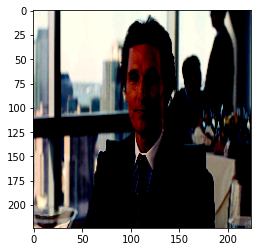

In [ ]:
#Test the model predictions on the test image

plt.imshow(X_test[3])

In [ ]:
y_pred = model.predict(np.array([X_test[3]]))
y_pred

1/1 [==============================] - 1s 1s/step


array([[[[0.06854425],
         [0.0272385 ],
         [0.03105058],
         ...,
         [0.03447665],
         [0.0382408 ],
         [0.15155931]],

        [[0.02276627],
         [0.01296067],
         [0.01681185],
         ...,
         [0.01935182],
         [0.01922422],
         [0.0379241 ]],

        [[0.03414628],
         [0.0193025 ],
         [0.02519458],
         ...,
         [0.02503731],
         [0.02163538],
         [0.03021044]],

        ...,

        [[0.02722943],
         [0.0183525 ],
         [0.02298721],
         ...,
         [0.02746876],
         [0.02682082],
         [0.03015387]],

        [[0.0306923 ],
         [0.02034183],
         [0.0299163 ],
         ...,
         [0.0235914 ],
         [0.02290014],
         [0.03019419]],

        [[0.07201144],
         [0.02863504],
         [0.02936957],
         ...,
         [0.02957879],
         [0.03531919],
         [0.05318065]]]], dtype=float32)

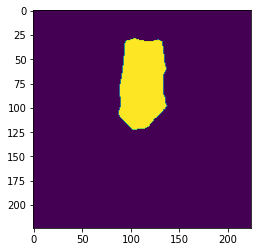

In [ ]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(pred_mask)

# **PART B**

In [ ]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/cv_2/training_images-20211126T092819Z-001.zip", 'r') as z:
  z.extractall()

In [ ]:
#getting unzipped folder location
dir_loc = z.filelist[0].filename.split("/")[0] 
dir_loc

'training_images'

In [ ]:
file_names = [os.path.join(dir_loc,i) for i in os.listdir(dir_loc)]
file_names[:5]

['training_images/real_00789.jpg',
 'training_images/real_00363.jpg',
 'training_images/real_00717.jpg',
 'training_images/real_00468.jpg',
 'training_images/real_00693.jpg']

In [ ]:
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output

#reading images

img_list = []
for imgs in tqdm(file_names):
  tst_img = cv2.imread(imgs)
  img_list.append(tst_img)
img_list = np.array(img_list)
display(Markdown(f"#### {img_list.shape}"))

  0%|          | 0/1091 [00:00<?, ?it/s]

#### (1091, 600, 600, 3)

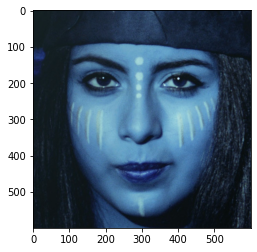

In [ ]:
#viewing random images
plt.imshow(img_list[10])

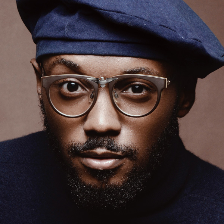

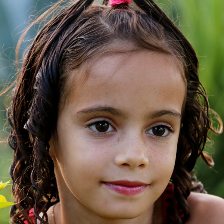

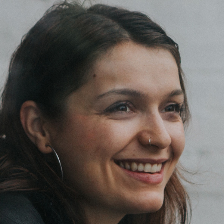

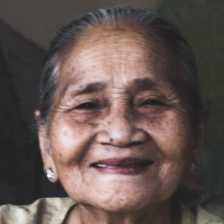

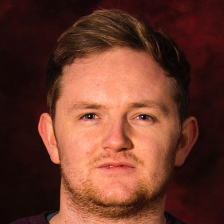

In [ ]:
from google.colab.patches import cv2_imshow

for i in img_list[:5,]:
  cv2_imshow(cv2.resize(i,(224,224)))

downloading haarcascade

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2023-01-15 15:26:49--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2023-01-15 15:26:49 (147 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

,x,y,w,h,Total_Faces,Image_Name


In [ ]:
%%time
haar_undetected_images = []
haar_detected_images = []
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for imgs, fnames in tqdm(zip(img_list,file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x, 
                  'y':y, 
                  'w':w,
                  'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 930 images

#### Failed to detect faces for 161 images

CPU times: user 5min 27s, sys: 2.94 s, total: 5min 30s
Wall time: 3min


In [ ]:
haar_img_box_df

,x,y,w,h,Total_Faces,Image_Name
0,68,89,411,411,1,training_images/real_00789.jpg
1,144,189,393,393,1,training_images/real_00363.jpg
2,219,153,354,354,1,training_images/real_00717.jpg
3,96,104,434,434,1,training_images/real_00468.jpg
4,115,156,383,383,1,training_images/real_00693.jpg
...,...,...,...,...,...,...
1006,78,166,407,407,1,training_images/real_00378.jpg
1007,91,121,438,438,1,training_images/real_00025.jpg
1008,36,77,485,485,1,training_images/real_00236.jpg
1009,83,93,430,430,1,training_images/real_00581.jpg


Out of a total of 1091 images, the HAAR was able to detect only 1011 images with one or more faces correctly.

In [ ]:
haar_img_box_df.to_csv('haar.csv')

# **PART C**

In [ ]:
with ZipFile("/content/drive/MyDrive/cv_2/PINS.zip", 'r') as z:
  z.extractall()

In [ ]:
dir_loc1 = z.filelist[0].filename.split("/")[0] 
dir_loc1

'PINS'

In [ ]:
file_names1 = [os.path.join(dir_loc1,i) for i in os.listdir(dir_loc1)]
file_names1

['PINS/pins_Sundar Pichai',
 'PINS/pins_Cameron Monaghan',
 'PINS/pins_Melissa benoit',
 'PINS/pins_Emma Stone',
 'PINS/pins_lindsey morgan face',
 'PINS/pins_Scarlett Johansson',
 'PINS/pins_drake',
 'PINS/pins_Natalie Portman ',
 'PINS/pins_jeff bezos',
 'PINS/pins_Amaury Nolasco',
 'PINS/pins_Chris Evans',
 'PINS/pins_Dave Franco',
 'PINS/pins_Morena Baccarin',
 'PINS/pins_mark zuckerberg',
 'PINS/pins_Alvaro Morte',
 'PINS/pins_elizabeth olsen face',
 'PINS/pins_maria pedraza',
 'PINS/pins_Morgan Freeman',
 'PINS/pins_Chance Perdomo',
 'PINS/pins_Thomas Middleditch',
 'PINS/pins_zendaya',
 'PINS/pins_millie bobby brown',
 'PINS/pins_Neil Patrick Harris',
 'PINS/pins_david mazouz',
 'PINS/pins_Sophie Turner',
 'PINS/pins_Stephen Amell',
 'PINS/pins_Jon Bernthal',
 'PINS/pins_shakira',
 'PINS/pins_grant gustin face',
 'PINS/pins_Caity Lotz',
 'PINS/pins_Krysten Ritter',
 'PINS/pins_Ursula Corbero',
 'PINS/pins_bellamy blake face',
 'PINS/pins_Kumail Nanjiani',
 'PINS/pins_Sebastian S

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

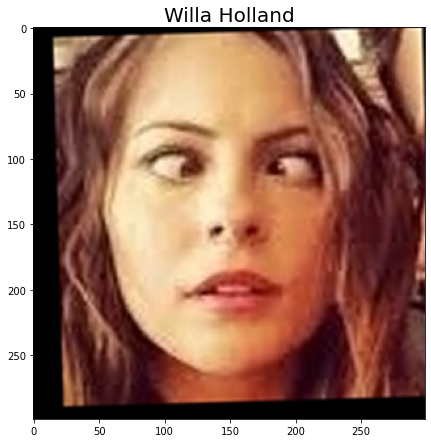

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [ ]:
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
model = vgg_face()
model.load_weights('/content/drive/MyDrive/cv_2/vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [ ]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

In [ ]:
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

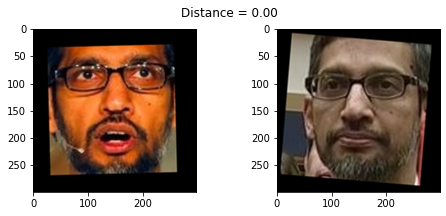

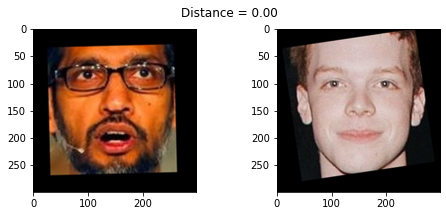

In [ ]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))

show_pair(2, 3)
show_pair(2, 180)

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [ ]:
# Encode labels
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [nan nan nan ... nan nan nan]


<ipython-input-60-ebcca84e101d>:9: RuntimeWarning: invalid value encountered in double_scalars
  var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]


In [ ]:
# Reducing the dimensions
random_state = 2020
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_base.py:122: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_base.py:122: RuntimeWarning: invalid value encountered in true_divide
  X_transformed /= np.sqrt(self.explained_variance_)


(9573, 408)

(1197, 408)

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))